In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import utils.functions as f

import warnings

warnings.filterwarnings("ignore", message="Warning")

2025-06-05 16:11:25.015230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/nlv19419/.pyenv/versions/3.11.12/envs/incartdb-venv/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


# Load the data
The export from the incart database is based on the header files of that database's format and some light processing in R. We load that file here and then continue the processing because most variables are factors that need to be transformed into numeric features.

In [14]:
dataset = "incartdb_demographics"
df = pd.read_csv(f"{dataset}.csv", sep=",")
df.head(10)

,header_file,id,age,gender,diagnoses,age_bin
0,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,F,"Coronary artery disease, arterial hypertension","(60,65]"
1,/Users/nlv19419/tmp/incartdb/files//I02.hea,2,65,F,"Coronary artery disease, arterial hypertension","(60,65]"
2,/Users/nlv19419/tmp/incartdb/files//I03.hea,3,59,M,Acute MI,"(55,60]"
3,/Users/nlv19419/tmp/incartdb/files//I04.hea,4,59,M,Acute MI,"(55,60]"
4,/Users/nlv19419/tmp/incartdb/files//I05.hea,5,59,M,Acute MI,"(55,60]"
5,/Users/nlv19419/tmp/incartdb/files//I06.hea,6,80,M,Transient ischemic attack,"(75,80]"
6,/Users/nlv19419/tmp/incartdb/files//I07.hea,7,80,M,Transient ischemic attack,"(75,80]"
7,/Users/nlv19419/tmp/incartdb/files//I08.hea,8,51,F,NaN,"(50,55]"
8,/Users/nlv19419/tmp/incartdb/files//I09.hea,9,68,M,NaN,"(65,70]"
9,/Users/nlv19419/tmp/incartdb/files//I10.hea,10,68,M,NaN,"(65,70]"


In [15]:
df['diagnoses'].value_counts()

diagnoses
Coronary artery disease, arterial hypertension, left ventricular hypertrophy    11
Earlier MI                                                                       9
Transient ischemic attack                                                        7
Coronary artery disease, arterial hypertension                                   6
Acute MI                                                                         6
Sinus node dysfunction                                                           2
Name: count, dtype: int64

So this shows that it makes sense to split on diagnosis so that we can count individual diagnoses.

In [17]:
df = df.assign(diagnoses=df['diagnoses'].str.split(', ')).explode('diagnoses')
df.rename(columns={'diagnoses': 'diagnosis'}, inplace=True)
df.head(10)

,header_file,id,age,gender,diagnosis,age_bin
0,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,F,Coronary artery disease,"(60,65]"
0,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,F,arterial hypertension,"(60,65]"
1,/Users/nlv19419/tmp/incartdb/files//I02.hea,2,65,F,Coronary artery disease,"(60,65]"
1,/Users/nlv19419/tmp/incartdb/files//I02.hea,2,65,F,arterial hypertension,"(60,65]"
2,/Users/nlv19419/tmp/incartdb/files//I03.hea,3,59,M,Acute MI,"(55,60]"
3,/Users/nlv19419/tmp/incartdb/files//I04.hea,4,59,M,Acute MI,"(55,60]"
4,/Users/nlv19419/tmp/incartdb/files//I05.hea,5,59,M,Acute MI,"(55,60]"
5,/Users/nlv19419/tmp/incartdb/files//I06.hea,6,80,M,Transient ischemic attack,"(75,80]"
6,/Users/nlv19419/tmp/incartdb/files//I07.hea,7,80,M,Transient ischemic attack,"(75,80]"
7,/Users/nlv19419/tmp/incartdb/files//I08.hea,8,51,F,NaN,"(50,55]"


In [18]:
df_processed = f.process_full_dataset(df, dataset_name=dataset)
df_processed.head(10)

,header_file,id,age,gender,diagnosis,age_bin
0,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,0,1,6
0,/Users/nlv19419/tmp/incartdb/files//I01.hea,1,65,0,5,6
1,/Users/nlv19419/tmp/incartdb/files//I02.hea,2,65,0,1,6
1,/Users/nlv19419/tmp/incartdb/files//I02.hea,2,65,0,5,6
2,/Users/nlv19419/tmp/incartdb/files//I03.hea,3,59,1,0,5
3,/Users/nlv19419/tmp/incartdb/files//I04.hea,4,59,1,0,5
4,/Users/nlv19419/tmp/incartdb/files//I05.hea,5,59,1,0,5
5,/Users/nlv19419/tmp/incartdb/files//I06.hea,6,80,1,4,9
6,/Users/nlv19419/tmp/incartdb/files//I07.hea,7,80,1,4,9
7,/Users/nlv19419/tmp/incartdb/files//I08.hea,8,51,0,7,4


### Correlation Matrix

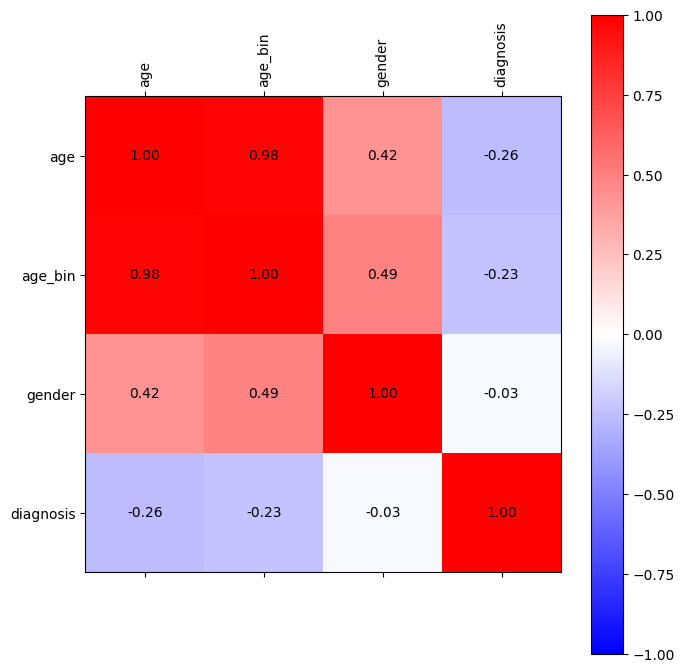

In [22]:
selected_columns = [
    "age",
    "age_bin",
    "gender", 
    "diagnosis"
]
f.plot_correlation_matrix(df_processed, selected_columns, figsize=(7,7))

# Bias Detection

## Gender Bias
Enconding:
- "Female": 0
- "Male": 1

In [5]:
df_processed.columns

Index(['cand_id', 'job_id', 'distance_km', 'match_score', 'match_rank',
       'cand_gender', 'cand_age_bucket', 'cand_domicile_province',
       'cand_domicile_region', 'cand_education', 'job_contract_type',
       'job_professional_category', 'job_sector', 'job_work_province',
       'Rumeno', 'Svedese', 'Arabo', 'Danese', 'Portoghese', 'Albanese',
       'Persiano', 'Spagnolo', 'Cinese', 'Ceco', 'Finlandese', 'Ebraico',
       'Serbo', 'Macedone', 'Croato', 'Tedesco'],
      dtype='object')

In [55]:
gender_bias = f.show_bias(df_processed, "cand_gender", 1, plot_histogram=True)

Skipped 3 jobs with no idoneous candidates in sector 0.
Skipped 6 jobs with no idoneous candidates in sector 4.
Skipped 7 jobs with no idoneous candidates in sector 7.
Skipped 8 jobs with no idoneous candidates in sector 2.
Skipped 3 jobs with no idoneous candidates in sector 9.
Skipped 6 jobs with no idoneous candidates in sector 3.
Skipped 5 jobs with no idoneous candidates in sector 6.


In [56]:
gender_bias.groupby("Sector")["Disparate_Impact"].describe()

,count,mean,std,min,25%,50%,75%,max
Sector,,,,,,,,
0,62.0,1.553677,1.951801,0.000000,0.331349,0.883598,1.988095,11.928571
1,10.0,1.283582,0.811418,0.238806,0.835821,1.432836,1.432836,3.223881
2,47.0,1.292536,1.058580,0.087636,0.481997,0.817935,1.402174,3.154891
3,34.0,1.360095,1.084921,0.144913,0.507194,0.788969,2.620504,3.043165
4,70.0,1.799874,1.379836,0.104839,0.629032,1.677419,3.774194,3.774194
5,157.0,1.609200,2.733702,0.000000,0.324982,0.731209,1.949891,26.323529
6,22.0,1.559176,1.267363,0.086683,0.462312,1.097990,3.120603,3.120603
7,276.0,1.381743,2.005795,0.000000,0.325852,0.868939,1.303409,11.730682
8,125.0,1.797275,3.000012,0.000000,0.276431,1.066234,1.658586,22.390909


In [57]:
sector_gender_bias = gender_bias[gender_bias["Sector"] == 4]
print("Tot: ", sector_gender_bias["Job"].count())
print(
    "Less than 0.8: ",
    sector_gender_bias[sector_gender_bias["Disparate_Impact"] < 0.8]["Job"].count(),
)
print(
    "Between: ",
    sector_gender_bias[
        (sector_gender_bias["Disparate_Impact"] >= 0.8)
        & (sector_gender_bias["Disparate_Impact"] < 1.3)
    ]["Job"].count(),
)
print(
    "More than 1.3",
    sector_gender_bias[sector_gender_bias["Disparate_Impact"] >= 1.3]["Job"].count(),
)

Tot:  70
Less than 0.8:  22
Between:  12
More than 1.3 36


In [58]:
sector_gender_bias.sort_values(by="Disparate_Impact", ascending=False)

,Sector,Job,Disparate_Impact,Statistical_Parity_Difference,DIDI
35,4,OFF_960_1411,3.774194,0.016415,0.011565
59,4,ORD_3923_1635,3.774194,0.016415,0.011565
36,4,ORD_10703_0555,3.774194,0.016415,0.011565
27,4,OFF_3624_1635,3.774194,0.016415,0.011565
24,4,OFF_3560_1635,3.774194,0.016415,0.011565
...,...,...,...,...,...
29,4,OFF_442_1681,0.179724,-0.033976,0.023938
8,4,OFF_2730_0310,0.179724,-0.033976,0.023938
38,4,ORD_14202_0595,0.104839,-0.042374,0.029855
6,4,OFF_2172_0102,0.104839,-0.042374,0.029855


In [59]:
gender_bias[["Disparate_Impact", "Statistical_Parity_Difference", "DIDI"]].corr()

,Disparate_Impact,Statistical_Parity_Difference,DIDI
Disparate_Impact,1.000000,0.475169,0.010368
Statistical_Parity_Difference,0.475169,1.000000,-0.535943
DIDI,0.010368,-0.535943,1.000000


### Region comparison

In [ ]:
gender_bias_lombardia = f.show_bias(df_lombardia, "cand_gender", 1, plot_histogram=True)
gender_bias_emilia = f.show_bias(df_emilia, "cand_gender", 1, plot_histogram=True)

In [13]:
gender_bias_lombardia.groupby("Sector")["Disparate_Impact"].describe()

,count,mean,std,min,25%,50%,75%,max
Sector,,,,,,,,
0,33.0,1.993002,2.895112,0.000000,0.157706,0.946237,2.365591,12.774194
1,8.0,1.053241,0.590374,0.401235,0.682099,0.962963,1.143519,2.166667
2,18.0,1.227977,1.020752,0.000000,0.383333,0.943590,1.415385,3.184615
3,20.0,1.396875,1.154942,0.250000,0.445313,0.875000,2.343750,3.375000
4,42.0,2.109434,1.659474,0.121324,0.727941,1.536765,4.367647,4.367647
5,93.0,1.462702,3.093362,0.000000,0.000000,0.692053,1.384106,24.913907
6,12.0,1.442474,1.487009,0.000000,0.258140,1.003876,2.151163,3.872093
7,126.0,1.295941,1.912911,0.000000,0.326984,0.653968,1.307937,11.771429
8,64.0,1.453834,2.286680,0.000000,0.000000,0.695489,1.715539,11.127820


In [16]:
gender_bias_emilia.groupby("Sector")["Disparate_Impact"].describe()


,count,mean,std,min,25%,50%,75%,max
Sector,,,,,,,,
0,19.0,1.217075,1.565867,0.0,0.000000,0.366279,2.197674,5.860465
1,2.0,0.583333,0.824958,0.0,0.291667,0.583333,0.875000,1.166667
2,12.0,0.969987,1.145513,0.0,0.300805,0.549296,1.098592,3.295775
3,8.0,0.922902,0.614284,0.0,0.645408,0.829365,1.571429,1.571429
4,6.0,0.895161,0.924561,0.0,0.435484,0.580645,1.052419,2.612903
5,37.0,1.420707,2.051465,0.0,0.000000,0.716346,1.432692,6.685897
6,7.0,1.476190,1.517517,0.0,0.400000,0.933333,2.500000,3.600000
7,45.0,1.000974,1.268762,0.0,0.000000,0.468132,1.092308,4.369231
8,31.0,0.924265,0.909060,0.0,0.000000,0.967980,1.505747,3.387931


## Location Bias

In [60]:
location_bias = f.show_bias(df_processed, "same_location", 1, plot_histogram=True)

Skipped 4 jobs with no idoneous candidates in sector 0.
Skipped 3 jobs with no idoneous candidates in sector 4.
Skipped 6 jobs with no idoneous candidates in sector 8.
Skipped 15 jobs with no idoneous candidates in sector 5.
Skipped 24 jobs with no idoneous candidates in sector 7.
Skipped 2 jobs with no idoneous candidates in sector 2.
Skipped 3 jobs with no idoneous candidates in sector 9.
Skipped 3 jobs with no idoneous candidates in sector 3.
Skipped 6 jobs with no idoneous candidates in sector 6.


In [61]:
location_bias.groupby("Sector")["Disparate_Impact"].describe()

,count,mean,std,min,25%,50%,75%,max
Sector,,,,,,,,
0,61.0,1.908632,2.664283,0.000000,0.288603,0.769608,2.693627,10.389706
1,10.0,1.630057,1.409194,0.142241,0.758621,1.327586,2.054850,5.120690
2,53.0,2.717351,3.920755,0.000000,0.155663,0.933977,3.268921,12.608696
3,37.0,1.952966,2.715943,0.000000,0.247326,0.659537,2.283688,8.903743
4,73.0,1.589397,2.450621,0.000000,0.324297,0.559908,1.945783,11.758065
5,142.0,1.847007,2.602538,0.000000,0.272174,0.729440,2.021024,9.831010
6,21.0,1.176284,1.589218,0.000000,0.196667,0.524444,1.835556,7.080000
7,259.0,2.104691,3.261898,0.000000,0.143234,0.846585,1.908632,11.474747
8,119.0,1.934512,2.963367,0.000000,0.318676,0.849802,1.912055,11.472332


In [62]:
sector_location_bias = location_bias[location_bias["Sector"] == 4]
print("Tot: ", sector_location_bias["Job"].count())
print(
    "Less than 0.8: ",
    sector_location_bias[sector_location_bias["Disparate_Impact"] < 0.8]["Job"].count(),
)
print(
    "Between: ",
    sector_location_bias[
        (sector_location_bias["Disparate_Impact"] >= 0.8)
        & (sector_location_bias["Disparate_Impact"] < 1.3)
    ]["Job"].count(),
)
print(
    "More than 1.3",
    sector_location_bias[sector_location_bias["Disparate_Impact"] >= 1.3][
        "Job"
    ].count(),
)

Tot:  73
Less than 0.8:  38
Between:  12
More than 1.3 23


In [63]:
sector_location_bias.sort_values(by="Disparate_Impact", ascending=False)

,Sector,Job,Disparate_Impact,Statistical_Parity_Difference,DIDI
67,4,ORD_4005_1635,11.758065,0.033204,0.014396
69,4,ORD_4030_1635,11.674699,0.033049,0.014387
30,4,OFF_3595_1635,11.674699,0.033049,0.014387
11,4,OFF_3394_4864,5.188755,0.025937,0.011291
32,4,OFF_4340_0035,5.188755,0.025937,0.011291
...,...,...,...,...,...
57,4,ORD_38011_3108,0.000000,-0.030960,0.013477
56,4,ORD_3750_1635,0.000000,-0.030488,0.013005
53,4,ORD_3712_1635,0.000000,-0.030675,0.013192
15,4,OFF_3428_1635,0.000000,-0.030960,0.013477


In [64]:
location_bias[["Disparate_Impact", "Statistical_Parity_Difference", "DIDI"]].corr()

,Disparate_Impact,Statistical_Parity_Difference,DIDI
Disparate_Impact,1.000000,0.545539,0.100078
Statistical_Parity_Difference,0.545539,1.000000,-0.251424
DIDI,0.100078,-0.251424,1.000000


### Region comparison

In [ ]:
location_bias_lombardia = f.show_bias(df_lombardia, "same_location", 1, plot_histogram=True)
location_bias_emilia = f.show_bias(df_emilia, "same_location", 1, plot_histogram=True)

In [19]:
location_bias_lombardia.groupby("Sector")["Disparate_Impact"].describe()

,count,mean,std,min,25%,50%,75%,max
Sector,,,,,,,,
0,32.0,1.944475,3.026007,0.000000,0.141197,0.782609,1.760870,10.565217
1,8.0,1.712435,1.466554,0.168750,0.664787,1.385791,2.193750,4.725000
2,18.0,1.804159,2.556385,0.000000,0.321597,0.977528,2.077247,9.000000
3,22.0,1.838867,2.169861,0.000000,0.332526,0.705405,2.843349,7.054054
4,41.0,1.418640,2.042375,0.000000,0.258389,0.671082,1.490132,8.707792
5,71.0,1.367978,1.773475,0.000000,0.246934,0.614865,2.114574,8.070000
6,9.0,1.102613,1.479848,0.000000,0.149351,0.746753,1.393939,4.779221
7,98.0,1.751295,2.607772,0.000000,0.235963,0.627506,1.535711,8.494652
8,55.0,2.072388,3.208145,0.000000,0.158861,0.555773,2.339367,11.484163


In [20]:
location_bias_emilia.groupby("Sector")["Disparate_Impact"].describe()

,count,mean,std,min,25%,50%,75%,max
Sector,,,,,,,,
0,12.0,0.751134,0.736010,0.000000,0.223214,0.459184,1.004464,2.083333
1,2.0,0.571429,0.404061,0.285714,0.428571,0.571429,0.714286,0.857143
2,11.0,2.193104,3.740898,0.000000,0.320121,0.776316,1.812340,12.825000
3,6.0,0.596522,0.507482,0.098039,0.259979,0.453782,0.794118,1.470588
4,6.0,1.105159,0.928859,0.000000,0.678571,0.732143,1.875000,2.250000
5,19.0,0.687466,0.878159,0.000000,0.075817,0.341176,0.887059,3.120155
6,4.0,0.687500,0.544862,0.000000,0.375000,0.812500,1.125000,1.125000
7,28.0,1.345780,2.086660,0.000000,0.122275,0.444733,1.706055,9.687023
8,20.0,0.907457,0.969479,0.000000,0.172673,0.527268,1.554054,3.626126


## Age Bias
Enconding:
- "15-24": 0
- "25-34": 1
- "35-44": 2
- "45-54": 3
- "55-74": 4

In [65]:
age_bias = f.show_bias(df_processed, "cand_age_bucket", 1, plot_histogram=True)

Skipped 1 jobs with no idoneous candidates in sector 8.
Skipped 2 jobs with no idoneous candidates in sector 5.
Skipped 6 jobs with no idoneous candidates in sector 7.
Skipped 4 jobs with no idoneous candidates in sector 2.
Skipped 1 jobs with no idoneous candidates in sector 3.


In [66]:
age_bias.groupby("Sector")["Disparate_Impact"].describe()

,count,mean,std,min,25%,50%,75%,max
Sector,,,,,,,,
0,65.0,1.493127,1.621764,0.084418,0.506507,1.139640,1.772773,6.837838
1,10.0,1.373469,1.187501,0.367347,0.571429,0.857143,1.821429,3.428571
2,51.0,1.458850,1.031153,0.140947,0.767380,1.315508,2.959893,2.959893
3,39.0,1.332807,1.009544,0.430769,0.646154,1.005128,1.723077,3.876923
4,76.0,1.407245,1.309268,0.090653,0.543915,1.223810,1.903704,7.342857
5,155.0,1.344250,1.179222,0.118405,0.710429,1.105112,1.894479,4.262577
6,27.0,1.526738,1.250524,0.288770,0.541444,1.010695,1.732620,3.898396
7,277.0,1.509060,1.166075,0.185361,0.648763,1.009187,1.730035,3.892580
8,124.0,1.464020,1.265382,0.133667,0.802000,1.247556,1.247556,4.812000


In [67]:
sector_age_bias = age_bias[age_bias["Sector"] == 3]
print("Tot: ", sector_age_bias["Job"].count())
print(
    "Less than 0.8: ",
    sector_age_bias[sector_age_bias["Disparate_Impact"] < 0.8]["Job"].count(),
)
print(
    "Between: ",
    sector_age_bias[
        (sector_age_bias["Disparate_Impact"] >= 0.8)
        & (sector_age_bias["Disparate_Impact"] < 1.3)
    ]["Job"].count(),
)
print(
    "More than 1.3",
    sector_age_bias[sector_age_bias["Disparate_Impact"] >= 1.3]["Job"].count(),
)

Tot:  39
Less than 0.8:  15
Between:  8
More than 1.3 16


In [68]:
sector_age_bias.sort_values(by="Disparate_Impact", ascending=False)

,Sector,Job,Disparate_Impact,Statistical_Parity_Difference,DIDI
0,3,OFF_14847_0059,3.876923,0.025687,0.017953
14,3,OFF_3857_0382,3.876923,0.025687,0.017953
24,3,OFF_689_1363,3.876923,0.025687,0.017953
21,3,OFF_5614_1636,3.876923,0.025687,0.017953
33,3,ORD_20852_0082,1.723077,0.012912,0.009025
30,3,ORD_15646_0073,1.723077,0.012912,0.009025
28,3,OFF_8709_1176,1.723077,0.012912,0.009025
25,3,OFF_7150_0583,1.723077,0.012912,0.009025
23,3,OFF_652_1708,1.723077,0.012912,0.009025
22,3,OFF_651_1708,1.723077,0.012912,0.009025


In [69]:
age_bias[["Disparate_Impact", "Statistical_Parity_Difference", "DIDI"]].corr()

,Disparate_Impact,Statistical_Parity_Difference,DIDI
Disparate_Impact,1.000000,0.581954,0.101340
Statistical_Parity_Difference,0.581954,1.000000,-0.117596
DIDI,0.101340,-0.117596,1.000000


### Region comparison

In [ ]:
age_bias_lombardia = f.show_bias(df_lombardia, "same_location", 1, plot_histogram=True)
age_bias_emilia = f.show_bias(df_emilia, "same_location", 1, plot_histogram=True)

In [22]:
age_bias_lombardia.groupby("Sector")["Disparate_Impact"].describe()

,count,mean,std,min,25%,50%,75%,max
Sector,,,,,,,,
0,32.0,1.944475,3.026007,0.000000,0.141197,0.782609,1.760870,10.565217
1,8.0,1.712435,1.466554,0.168750,0.664787,1.385791,2.193750,4.725000
2,18.0,1.804159,2.556385,0.000000,0.321597,0.977528,2.077247,9.000000
3,22.0,1.838867,2.169861,0.000000,0.332526,0.705405,2.843349,7.054054
4,41.0,1.418640,2.042375,0.000000,0.258389,0.671082,1.490132,8.707792
5,71.0,1.367978,1.773475,0.000000,0.246934,0.614865,2.114574,8.070000
6,9.0,1.102613,1.479848,0.000000,0.149351,0.746753,1.393939,4.779221
7,98.0,1.751295,2.607772,0.000000,0.235963,0.627506,1.535711,8.494652
8,55.0,2.072388,3.208145,0.000000,0.158861,0.555773,2.339367,11.484163


In [23]:
age_bias_emilia.groupby("Sector")["Disparate_Impact"].describe()

,count,mean,std,min,25%,50%,75%,max
Sector,,,,,,,,
0,12.0,0.751134,0.736010,0.000000,0.223214,0.459184,1.004464,2.083333
1,2.0,0.571429,0.404061,0.285714,0.428571,0.571429,0.714286,0.857143
2,11.0,2.193104,3.740898,0.000000,0.320121,0.776316,1.812340,12.825000
3,6.0,0.596522,0.507482,0.098039,0.259979,0.453782,0.794118,1.470588
4,6.0,1.105159,0.928859,0.000000,0.678571,0.732143,1.875000,2.250000
5,19.0,0.687466,0.878159,0.000000,0.075817,0.341176,0.887059,3.120155
6,4.0,0.687500,0.544862,0.000000,0.375000,0.812500,1.125000,1.125000
7,28.0,1.345780,2.086660,0.000000,0.122275,0.444733,1.706055,9.687023
8,20.0,0.907457,0.969479,0.000000,0.172673,0.527268,1.554054,3.626126
